### Importing Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_style('whitegrid')
%matplotlib inline

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

#pickle
import pickle

#LdaVis
import pyLDAvis.gensim

#nltk
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tkaramya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tkaramya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Loading TripAdvisor Dataset

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

### Check for Na's

In [6]:
df = df[:10000]

In [7]:
for i in df.columns:
    print(i,"--------->", df[i].nunique())

Review ---------> 10000
Rating ---------> 5


In [8]:
for col in df.columns:
    A = df.loc[:col].isnull().sum()
print(A)
print("Review length =", len(df.Review))

Review    0
Rating    0
dtype: int64
Review length = 10000


### Preprocessing The Dataset

In [9]:
df.Review.to_list()

['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  ',
 'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom un

### Stopwords also should be Eliminated (If There Is)

---
Stop words: Stop Words are words which do not contain important significance to be used in Search Queries. Usually, these words are filtered out from search queries because they return a vast amount of unnecessary information. Each programming language will give its own list of stop words to use. Mostly they are words that are commonly used in the English language such as 'as, the, be, are' etc.

### NLTK 

---
<b>Stemming</b> and <b>Lemmatization</b> are <b>Text Normalization</b> (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. 
* Python <b>nltk</b> package = <i>Natural Language Tool Kit</i> package provided by Python for Natural Language Processing tasks.

Stemming and Lemmatization helps us to achieve the root forms (sometimes called synonyms in search context) of inflected (derived) words. 

---
Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced. Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language."
* <b>Stem (root) is the part of the word to which you add inflectional (changing/deriving) affixes such as (-ed,-ize, -s,-de,mis)</b>. So stemming a word or sentence may result in words that are not actual words. Stems are created by removing the suffixes or prefixes used with a word.
Python <b>nltk</b> provides not only two <b>English</b> stemmers: <b>PorterStemmer</b> and <b>LancasterStemmer</b> but also a lot of <b>non-English</b> stemmers as part of <b>SnowballStemmers</b>, ISRIStemmer, RSLPSStemmer. Python NLTK included SnowballStemmers as a language to create non-English stemmers. One can program one's own language stemmer using snowball. Currently, it supports the following languages:Danish, Dutch, English, French, German, Hungarian, Italian, Norwegian, Porter, Portuguese, Romanian, <i>Russian</i>, Spanish, Swedish

---
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.
* Python NLTK provides WordNet Lemmatizer that uses the WordNet Database to lookup lemmas of words.
* print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word, <b>pos="v"</b>)))

---
To separate the sentence into words, you can use <b>tokenizer</b>. The nltk tokenizer separates the sentence into words.
* from nltk.tokenize import sent_tokenize, word_tokenize

#### Instructions 
* Take a document as the input.
* Read the document line by line ---> [Check this for Russian Stemmer](https://snowballstem.org/algorithms/russian/stemmer.html)
* Tokenize the line
* Stem the words ---> [What is NLTK](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9062692&gclid=EAIaIQobChMIzceX_e7b7AIVkakYCh0n6ArOEAAYASAAEgK4BPD_BwE)
* Output the stemmed words (print on screen or write to a file)
* Repeat step 2 to step 5 until it is to the end of the document.
* <b>TF-IDF</b> ---> [TF–IDF term weighting](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
* <b>Topic Modeling (Latent Semantics)</b> --->    [Might be Helpful](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

In [10]:
%%time
stemmer = SnowballStemmer('english') 
stops = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def stemming_(Sentence):
    cleaned_ver = []
    for word in word_tokenize(Sentence):
        if word not in stops and word.isalnum():
            cleaned_ver.append(stemmer.stem(word))
    return ' '.join(cleaned_ver)

def lemmatize_(Sentence):
    cleaned_ver = []
    for word in word_tokenize(Sentence):
        if word not in stops and word.isalnum():
            cleaned_ver.append(lemmatizer.lemmatize(word))
    return ' '.join(cleaned_ver)

Wall time: 5.99 ms


In [11]:
%%time
df["Stem_Review"] = 0
df["Lemm_Review"] = 0

Wall time: 2.98 ms


In [12]:
%%time
df.Stem_Review = df.Review.apply(lambda x: stemming_(x))
df.Lemm_Review = df.Review.apply(lambda y: lemmatize_(y))

Wall time: 49.2 s


In [13]:
df.head(20)

,Review,Rating,Stem_Review,Lemm_Review
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room 4 experi hotel monaco seattl good ho...,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...
5,love monaco staff husband stayed hotel crazy w...,5,love monaco staff husband stay hotel crazi wee...,love monaco staff husband stayed hotel crazy w...
6,"cozy stay rainy city, husband spent 7 nights m...",5,cozi stay raini citi husband spent 7 night mon...,cozy stay rainy city husband spent 7 night mon...
7,"excellent staff, housekeeping quality hotel ch...",4,excel staff housekeep qualiti hotel chock staf...,excellent staff housekeeping quality hotel cho...
8,"hotel stayed hotel monaco cruise, rooms genero...",5,hotel stay hotel monaco cruis room generous de...,hotel stayed hotel monaco cruise room generous...
9,excellent stayed hotel monaco past w/e delight...,5,excel stay hotel monaco past delight recept st...,excellent stayed hotel monaco past delight rec...


### WordCloud

---
To verify whether the <b>preprocessing</b> happened correctly, we’ll make a word cloud using the <b>wordcloud</b> package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

---

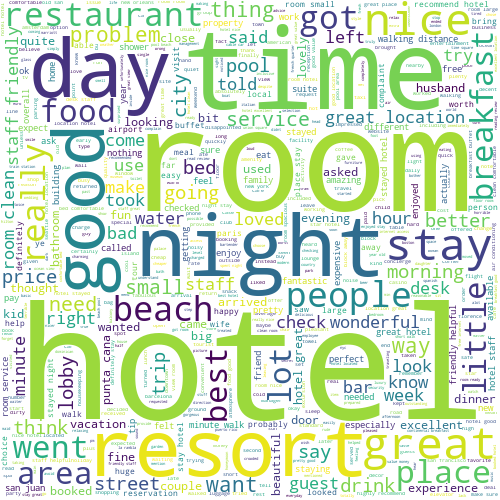

In [14]:
long_string2 = ','.join(list(df.Lemm_Review.values))
wordcloud = WordCloud(background_color = "white", width = 500, height = 500, max_words = 5000, contour_width = 20)
wordcloud.generate(long_string2)
wordcloud.to_image()

### Unigram and Trigram: 

In [15]:
Unigram_vectorizer = CountVectorizer()
Trigram_vectorizer = CountVectorizer(ngram_range = (3, 3),
                                    token_pattern = r'\b\w+\b', min_df=1)

In [16]:
def plot_15_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:15]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='15 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

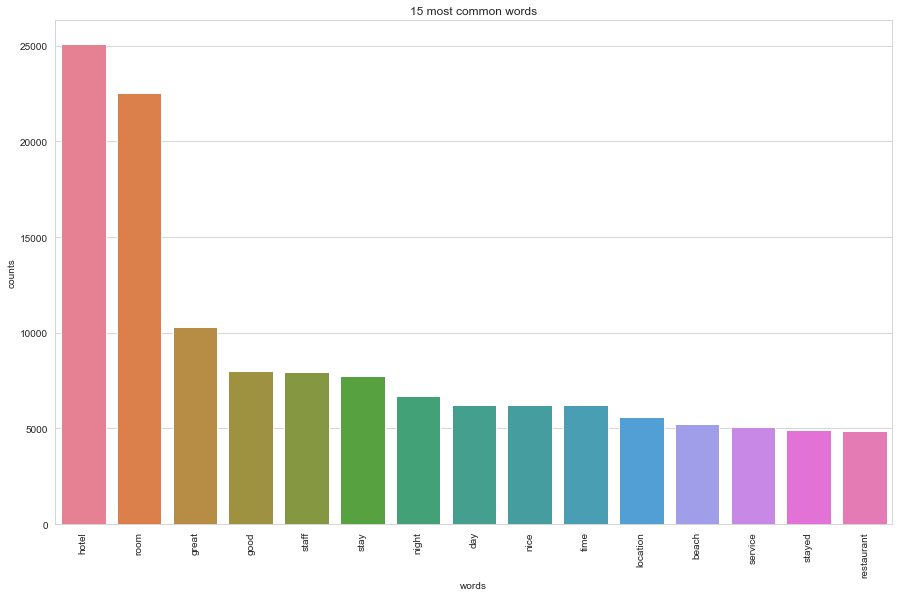

Wall time: 2.62 s


In [17]:
%%time
Unigram_data = Unigram_vectorizer.fit_transform(df.Lemm_Review)
plot_15_most_common_words(Unigram_data, Unigram_vectorizer)

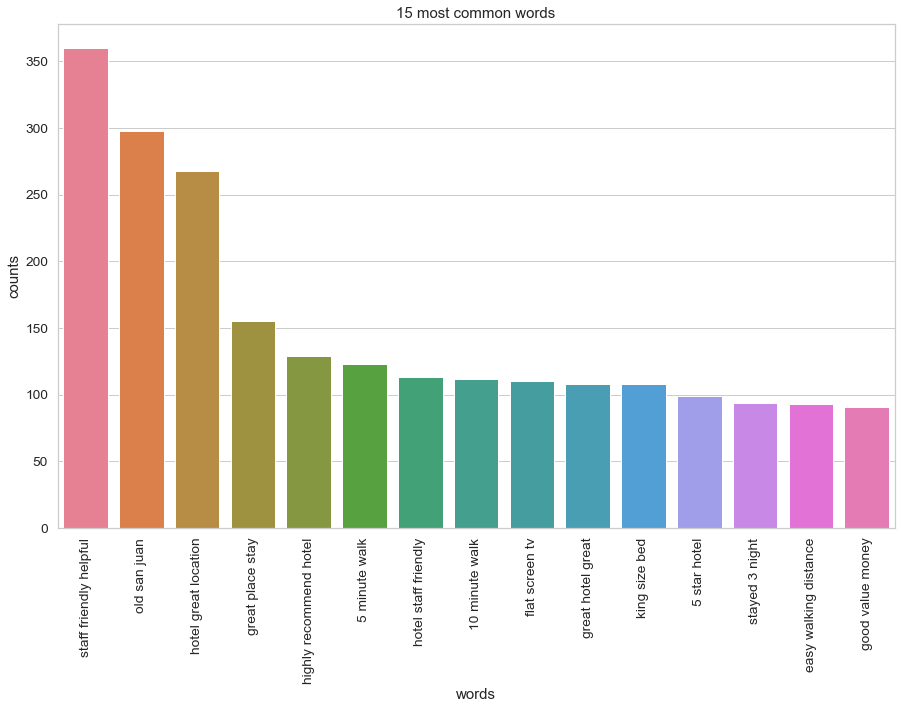

Wall time: 55 s


In [18]:
%%time
Trigram_data = Trigram_vectorizer.fit_transform(df.Lemm_Review)
plot_15_most_common_words(Trigram_data, Trigram_vectorizer)

### TF-IDF on Trigram

In a large text corpus, some words will be very present hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

Tf means <b>term-frequency</b> while <i>tf–idf</i> means term-frequency times <b>inverse document-frequency</b>:

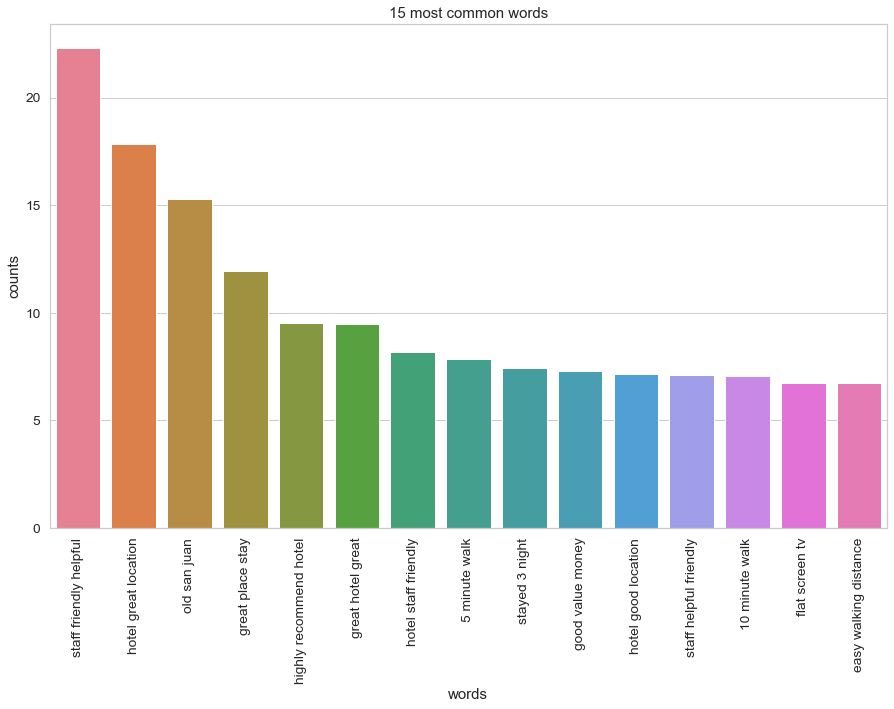

Wall time: 51.8 s


In [19]:
%%time
Vectorizer = TfidfVectorizer(ngram_range = (3, 3),
                                    token_pattern = r'\b\w+\b', min_df=1)
Data = Vectorizer.fit_transform(df.Lemm_Review)
plot_15_most_common_words(Data, Vectorizer)

As <b>tf–idf</b> is very often used for text features, there is also another class called <b>TfidfVectorizer</b> that combines all the options of <b>CountVectorizer</b> and <b>TfidfTransformer</b> in a single model.

While the tf–idf normalization is often very useful, there might be cases where the binary occurrence markers might offer better features. This can be achieved by using the binary parameter of CountVectorizer. In particular, some estimators such as Bernoulli Naive Bayes explicitly model discrete boolean random variables. Also, very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable.

### Loading LDA

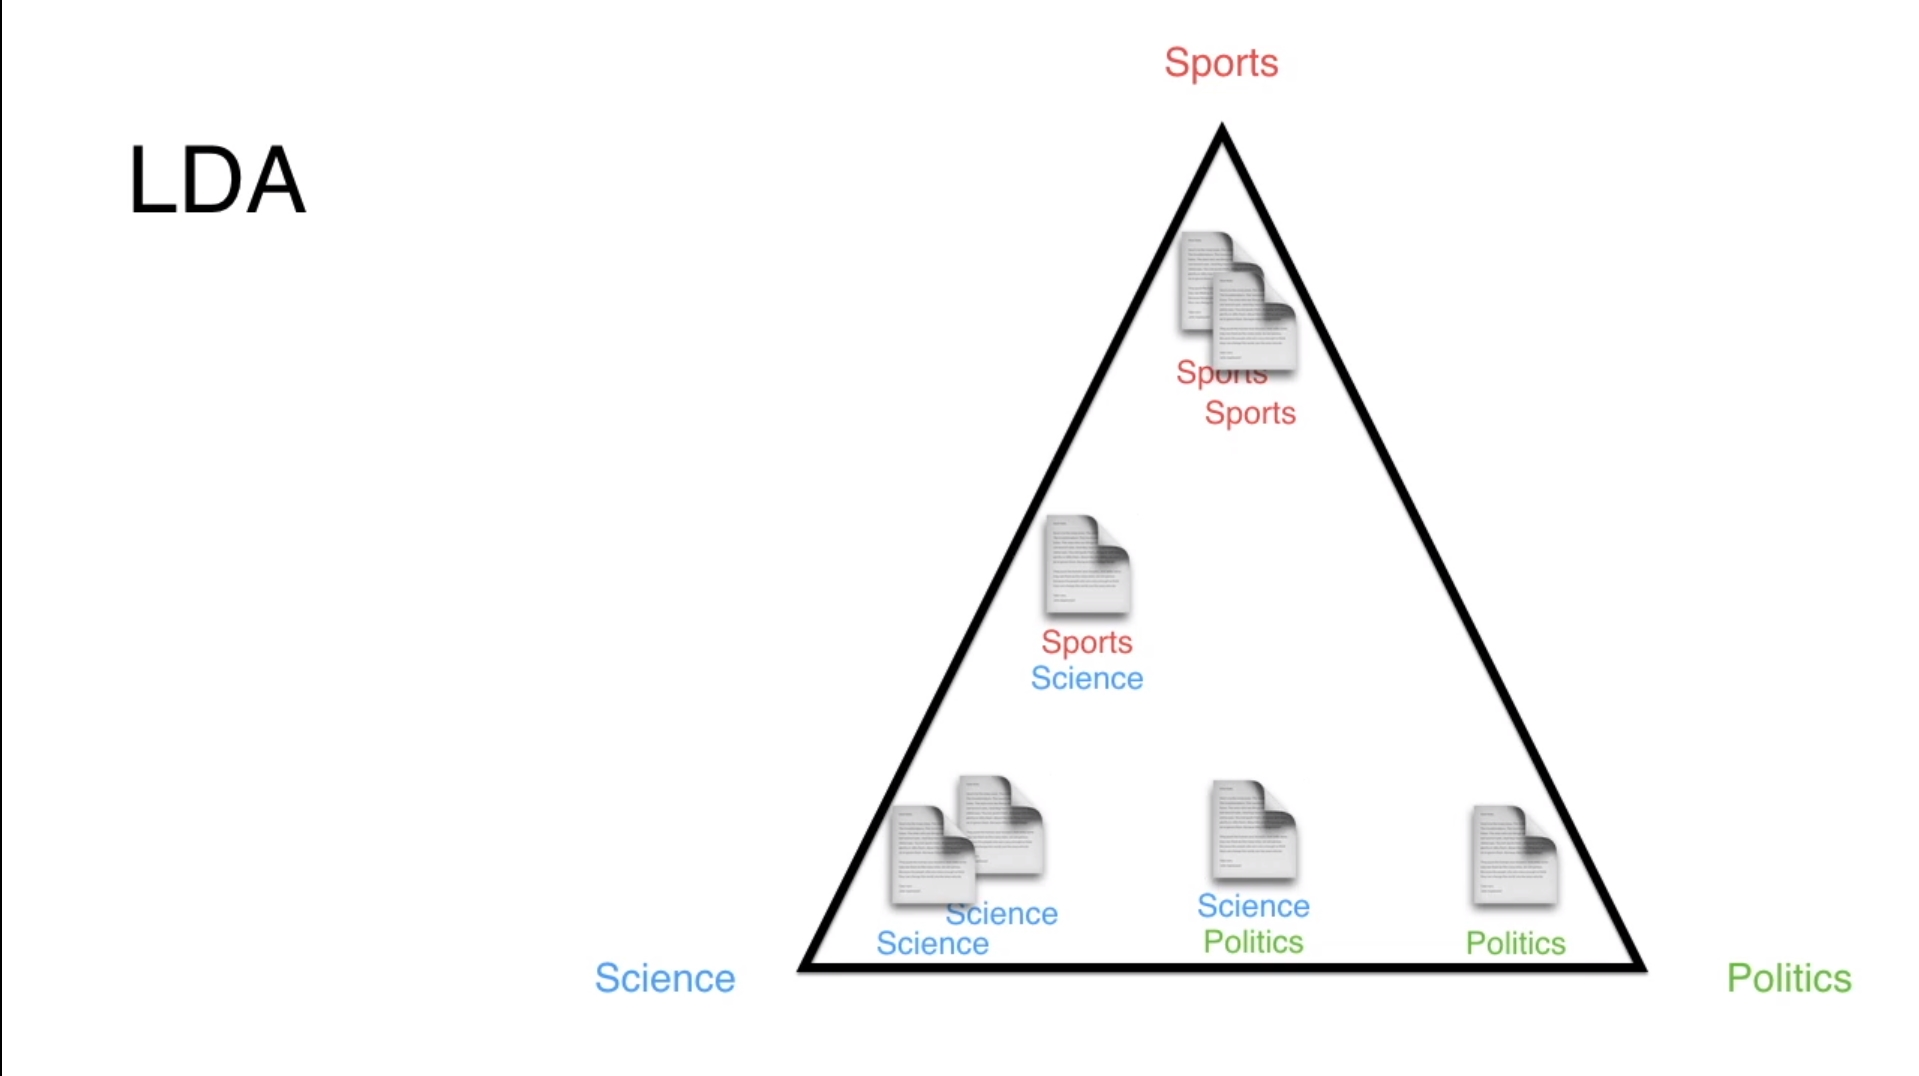

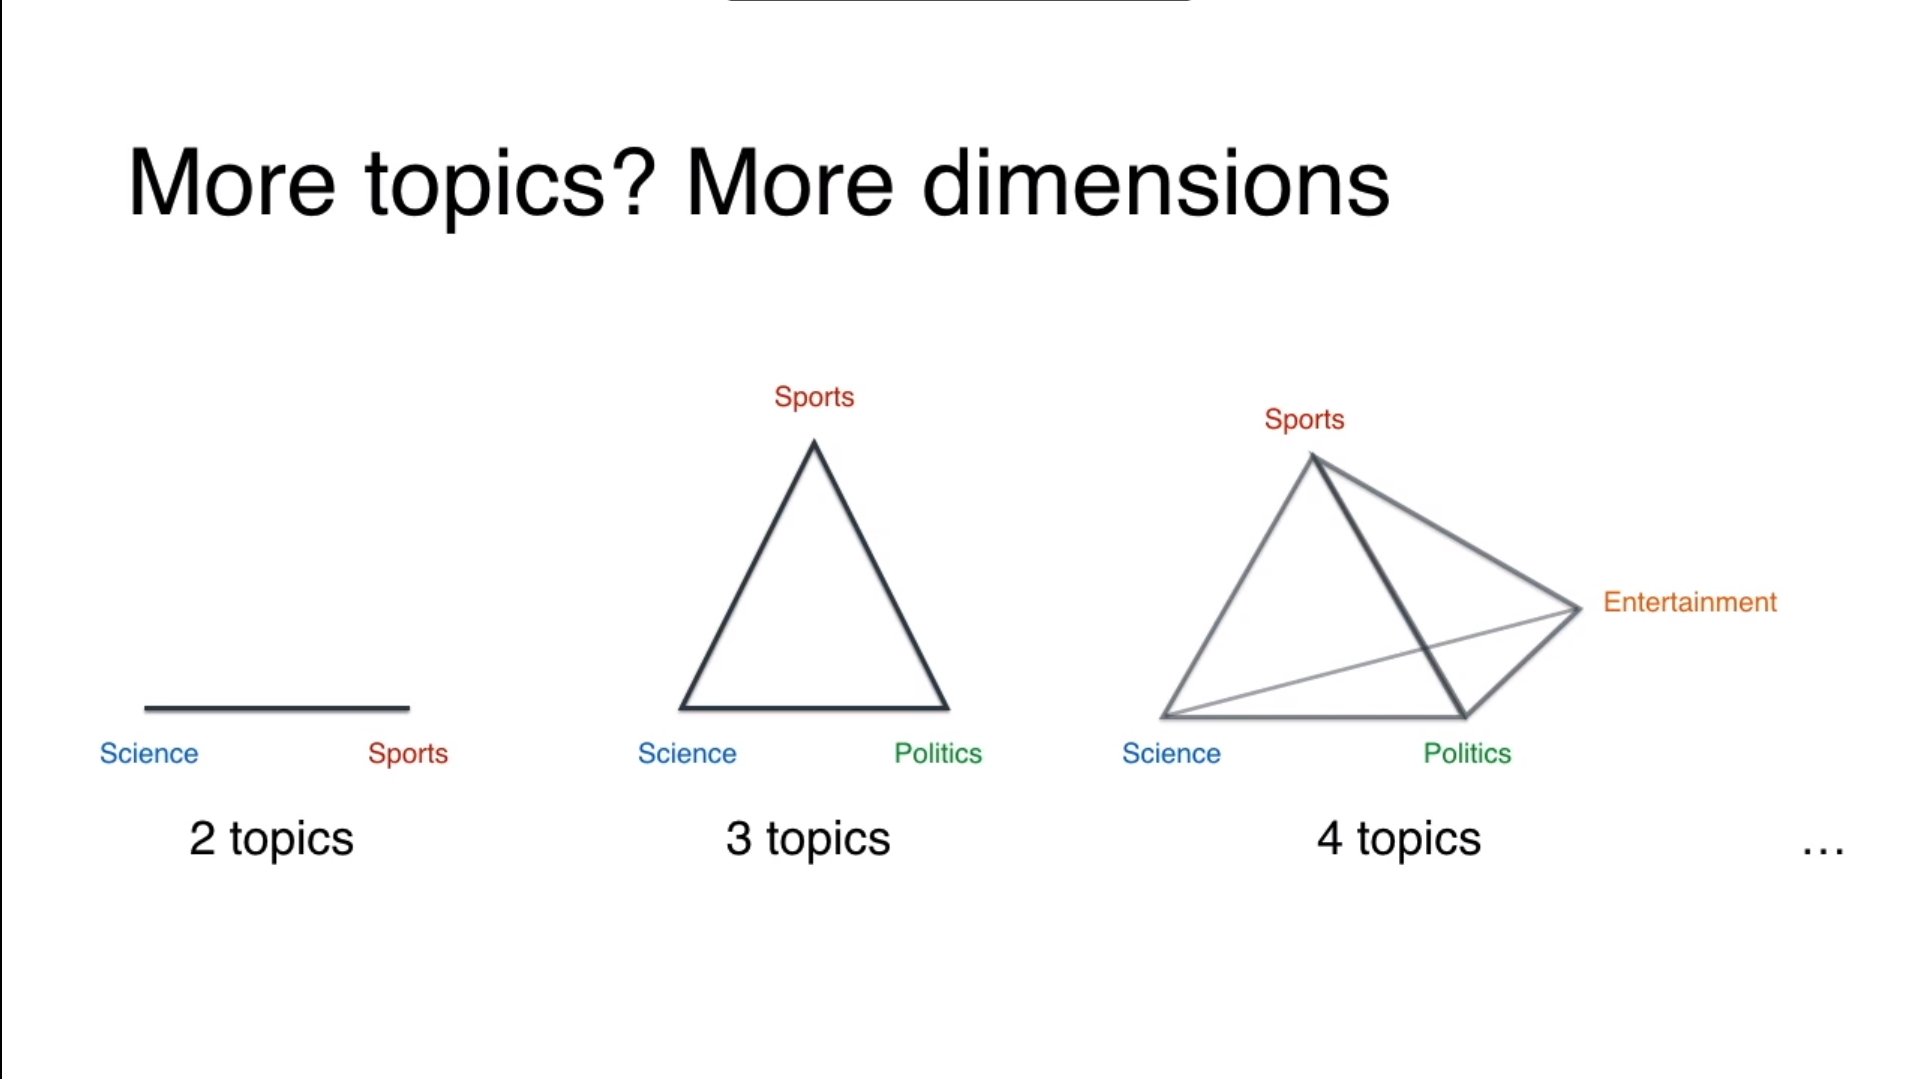

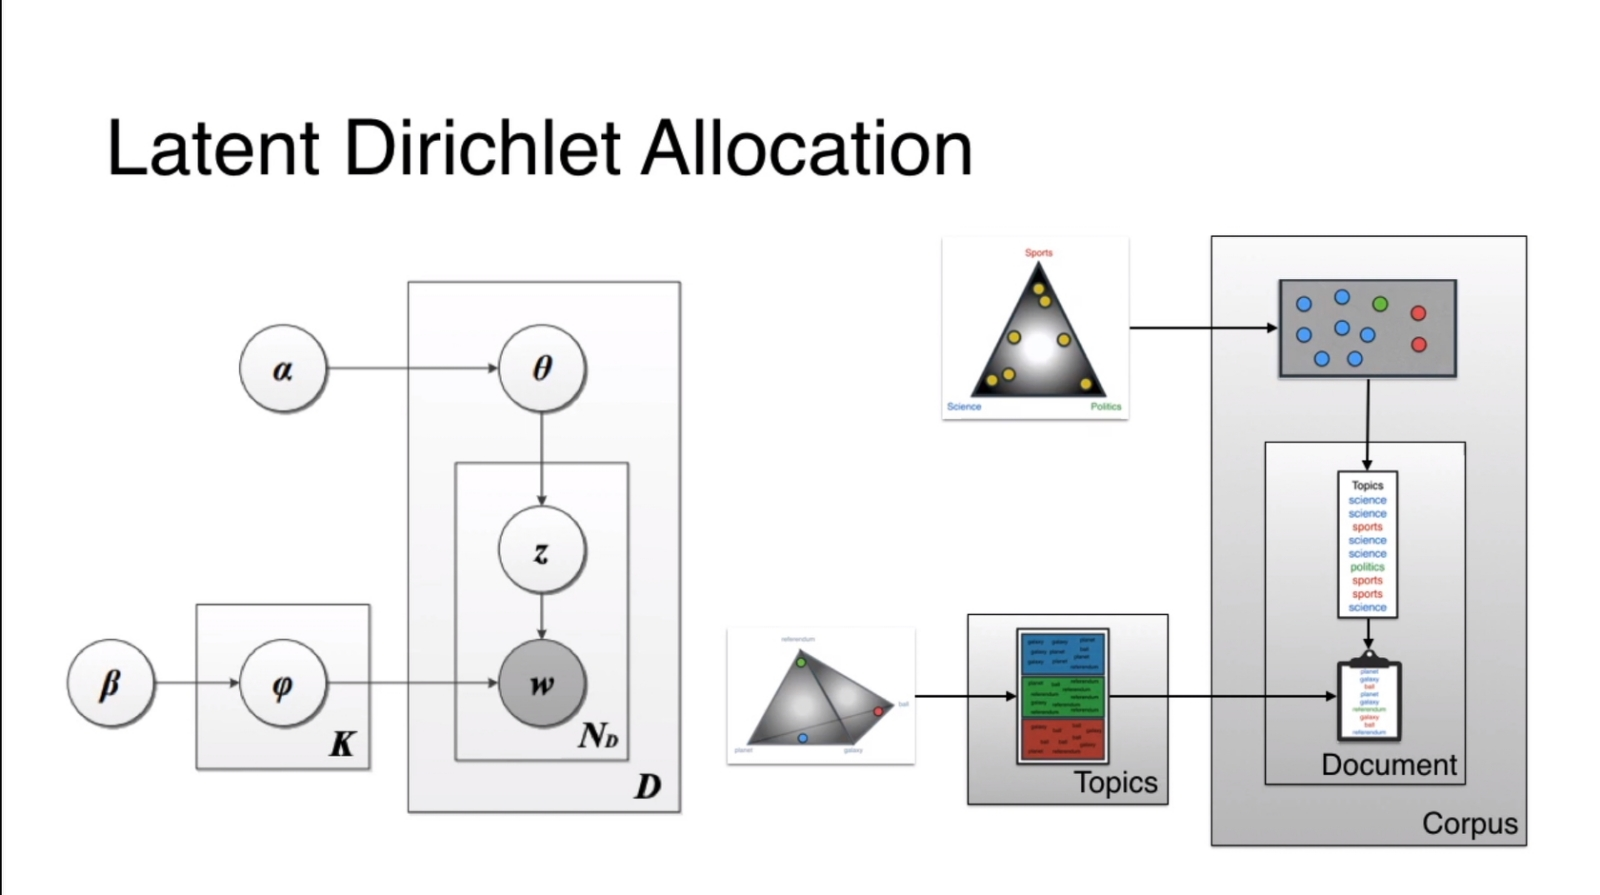

In [20]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [21]:
def print_topics(model, count_vectorizer, n_top_words):
    
    words = Vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [22]:
number_topics = 3
number_words = 4

lda = LDA(number_topics, n_jobs = None)
lda.fit(Data)

print("Topics found via LDA:")
print_topics(lda, Vectorizer, number_words)

Topics found via LDA:

Topic #0:
staff friendly helpful old san juan hotel great location great place stay

Topic #1:
staff friendly helpful hotel great location old san juan great place stay

Topic #2:
staff friendly helpful hotel great location old san juan great place stay


### More Detailed LDA 

In [23]:
text_data = [word_tokenize(i) for i in df.Lemm_Review]

In [24]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [25]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('40', 1),
  ('advantage', 1),
  ('advice', 1),
  ('anniversary', 1),
  ('arrived', 1),
  ('aveda', 1),
  ('bang', 1),
  ('bath', 1),
  ('bed', 1),
  ('check', 1),
  ('clean', 1),
  ('closing', 1),
  ('comfortable', 1),
  ('deal', 1),
  ('disappointed', 1),
  ('distance', 1),
  ('door', 1),
  ('easy', 1),
  ('evening', 1),
  ('expensive', 1),
  ('experience', 1),
  ('goldfish', 1),
  ('good', 1),
  ('got', 1),
  ('great', 1),
  ('hallway', 1),
  ('hear', 1),
  ('heard', 1),
  ('high', 1),
  ('hotel', 2),
  ('late', 1),
  ('like', 1),
  ('little', 1),
  ('location', 1),
  ('longer', 1),
  ('loud', 1),
  ('maybe', 1),
  ('morning', 1),
  ('music', 1),
  ('neck', 1),
  ('neighbor', 1),
  ('nice', 5),
  ('night', 2),
  ('noisy', 1),
  ('opening', 1),
  ('overall', 1),
  ('parking', 3),
  ('pay', 1),
  ('people', 1),
  ('pillow', 1),
  ('previous', 1),
  ('product', 1),
  ('quick', 1),
  ('review', 1),
  ('room', 3),
  ('shopping', 1),
  ('size', 1),
  ('soundproof', 1),
  ('stay', 2),
  

In addition to the <b>corpus</b> and <b>dictionary</b>, you need to provide the <b>number of topics</b> as well. <b>Chunksize</b> is the number of documents to be used in each training chunk. <b>Passes</b> is the total number of training passes.

In [60]:
%%time
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 19, id2word=dictionary, passes=25, random_state=76)
ldamodel.save('model.gensim')

topics = ldamodel.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.079*"waikiki" + 0.047*"view" + 0.040*"beach" + 0.029*"ocean" + 0.023*"hawaii" + 0.016*"pro" + 0.014*"con"')
(1, '0.035*"hotel" + 0.034*"san" + 0.032*"great" + 0.027*"car" + 0.021*"stay" + 0.021*"place" + 0.019*"parking"')
(2, '0.039*"hotel" + 0.014*"service" + 0.014*"room" + 0.012*"area" + 0.012*"free" + 0.011*"nice" + 0.011*"business"')
(3, '0.050*"room" + 0.032*"hotel" + 0.016*"desk" + 0.014*"told" + 0.012*"day" + 0.012*"night" + 0.010*"time"')
(4, '0.026*"beach" + 0.022*"pool" + 0.016*"great" + 0.015*"good" + 0.014*"food" + 0.013*"restaurant" + 0.013*"room"')
(5, '0.062*"room" + 0.044*"hotel" + 0.021*"good" + 0.016*"night" + 0.016*"nice" + 0.015*"bed" + 0.015*"location"')
(6, '0.018*"service" + 0.011*"like" + 0.010*"time" + 0.009*"food" + 0.008*"review" + 0.008*"day" + 0.007*"staff"')
(7, '0.072*"hotel" + 0.026*"staff" + 0.026*"room" + 0.026*"great" + 0.020*"location" + 0.019*"stay" + 0.013*"helpful"')
(8, '0.020*"year" + 0.014*"wonderful" + 0.011*"like" + 0.011*"barcelona" +

How to interpret this?

Topic 0 is a represented as '0.079*"waikiki" + 0.047*"view" + 0.042*"beach" + 0.029*"ocean" + 0.024*"hawaii" + 0.016*"pro" + 0.015*"outrigger"

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be?

In [61]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.678332357471923

Coherence Score:  0.4759678376906169


In [62]:
%%time
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model.gensim')

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Wall time: 36.3 s


So how to infer pyLDAvis’s output?

* Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

* A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

* A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

* Salient keywords form the selected topic.


### How to find the optimal number of topics for LDA?

In [63]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=25, random_state=76)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus, texts=text_data, start=5, limit=20, step=5)

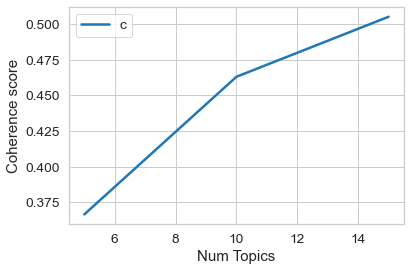

In [68]:
# Show graph
limit=20 
start=5 
step=5
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The overall coherence score of a topic is the average of the distances between words.

0.3 is bad

0.4 is low (probably have the wrong number of topics )

0.55 is okay

0.65 might be as good as it is going to get

0.7 is nice

0.8 is unlikely and

0.9 is probably wrong

In [66]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3666
Num Topics = 10  has Coherence Value of 0.4631
Num Topics = 15  has Coherence Value of 0.5051


### Dominant Topic in Each Comment

In [67]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=df.Lemm_Review.tolist()):

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Percentage_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, pd.Series(texts)], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, 
                                                  texts=df.Lemm_Review.tolist())

# Format

df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Percentage_Contrib', 'Keywords', 'Comments']

# Show
df_dominant_topic.sort_values(['Dominant_Topic'])

,Dominant_Topic,Topic_Percentage_Contrib,Keywords,Comments
6221,0.0,0.3216,"waikiki, view, beach, ocean, hawaii, pro, con,...",absolutely best beach waikiki absolutely best ...
1338,0.0,0.2369,"waikiki, view, beach, ocean, hawaii, pro, con,...",excellent location price excellent location pr...
1877,1.0,0.3810,"hotel, san, great, car, stay, place, parking, ...",awesome customer service ca express impressed ...
7417,1.0,0.2685,"hotel, san, great, car, stay, place, parking, ...",like old car new paint booked expedia month ad...
1625,1.0,0.4159,"hotel, san, great, car, stay, place, parking, ...",chancellor hotel exceeded expectation chancell...
...,...,...,...,...
6265,18.0,0.3044,"customer, group, property, travel, conference,...",desk representative desk representative alliso...
2895,18.0,0.3459,"customer, group, property, travel, conference,...",best vacation bavaro princess punta cana dom v...
3475,18.0,0.2188,"customer, group, property, travel, conference,...",intercontinental dream come true dreamed takin...
522,18.0,0.4497,"customer, group, property, travel, conference,...",great potential want special thanks animation ...


### Part Of Speech tagging: Using only Nouns and Adjectives

In [116]:
def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == "NN" or pos[:2] == "JJ"
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

In [117]:
df["Noun_Adj"] = 0
df.Noun_Adj = df.Lemm_Review.apply(nouns_adj)
df.head(20)

,Review,Rating,Stem_Review,Lemm_Review,Noun_Adj
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...,nice hotel expensive parking got good deal sta...,nice hotel expensive parking good deal hotel a...
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room 4 experi hotel monaco seattl good ho...,nice room 4 experience hotel monaco seattle go...,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,great stay great stay seahawk game awesome dow...
5,love monaco staff husband stayed hotel crazy w...,5,love monaco staff husband stay hotel crazi wee...,love monaco staff husband stayed hotel crazy w...,monaco staff husband hotel crazy weekend memor...
6,"cozy stay rainy city, husband spent 7 nights m...",5,cozi stay raini citi husband spent 7 night mon...,cozy stay rainy city husband spent 7 night mon...,cozy stay rainy city husband night monaco janu...
7,"excellent staff, housekeeping quality hotel ch...",4,excel staff housekeep qualiti hotel chock staf...,excellent staff housekeeping quality hotel cho...,excellent staff quality hotel staff feel home ...
8,"hotel stayed hotel monaco cruise, rooms genero...",5,hotel stay hotel monaco cruis room generous de...,hotel stayed hotel monaco cruise room generous...,hotel hotel monaco cruise room generous hotel ...
9,excellent stayed hotel monaco past w/e delight...,5,excel stay hotel monaco past delight recept st...,excellent stayed hotel monaco past delight rec...,excellent hotel monaco delight reception staff...


In [118]:
text_data_nnjj = [word_tokenize(i) for i in df.Noun_Adj]

In [119]:
dictionarynnjj = corpora.Dictionary(text_data_nnjj)
corpusnnjj = [dictionarynnjj.doc2bow(text) for text in text_data_nnjj]

pickle.dump(corpus, open('corpusnnjj.pkl', 'wb'))
dictionary.save('dictionarynnjj.gensim')

### Coherence Score for only N. and Adj. Filtered Data

In [120]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionarynnjj,
                                                        corpus=corpusnnjj, texts=text_data_nnjj, start=10, limit=30, step=9)

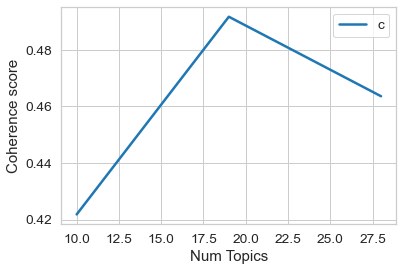

In [121]:
# Show graph
limit=30; start=10; step=9;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [122]:
%%time
ldamodelnnjj = gensim.models.ldamodel.LdaModel(corpusnnjj, num_topics = 19, id2word=dictionarynnjj, passes=25, random_state=76)
ldamodelnnjj.save('modelnj.gensim')

topics = ldamodelnnjj.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.071*"hotel" + 0.030*"room" + 0.029*"good" + 0.019*"location" + 0.018*"great" + 0.014*"walk" + 0.013*"night"')
(1, '0.049*"del" + 0.044*"medical" + 0.030*"sol" + 0.020*"pig" + 0.020*"easter" + 0.017*"ramada" + 0.014*"traveled"')
(2, '0.051*"hotel" + 0.026*"service" + 0.020*"staff" + 0.014*"room" + 0.011*"stay" + 0.009*"time" + 0.009*"best"')
(3, '0.210*"majestic" + 0.071*"expedia" + 0.016*"magic" + 0.015*"glorious" + 0.014*"excelent" + 0.005*"petite" + 0.003*"pat"')
(4, '0.078*"pool" + 0.045*"beach" + 0.033*"view" + 0.032*"villa" + 0.028*"area" + 0.018*"spa" + 0.018*"ocean"')
(5, '0.146*"royal" + 0.039*"baby" + 0.021*"recomend" + 0.020*"jr" + 0.019*"crew" + 0.017*"crib" + 0.015*"soo"')
(6, '0.108*"el" + 0.076*"ferry" + 0.045*"r" + 0.027*"railway" + 0.023*"battery" + 0.015*"physical" + 0.014*"stool"')
(7, '0.088*"room" + 0.055*"hotel" + 0.019*"night" + 0.013*"stay" + 0.012*"time" + 0.012*"desk" + 0.012*"day"')
(8, '0.012*"water" + 0.008*"place" + 0.007*"thing" + 0.007*"day" + 0.00

In [124]:
%%time
dictionary = gensim.corpora.Dictionary.load('dictionarynnjj.gensim')
corpus = pickle.load(open('corpusnnjj.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('modelnj.gensim')

lda_display = pyLDAvis.gensim.prepare(lda, corpusnnjj, dictionarynnjj, sort_topics=False)
pyLDAvis.display(lda_display)

Wall time: 47.9 s
